In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import copy
import gurobipy as gp
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import quad, trapezoid
from tqdm import tqdm
from scipy.special import lambertw

sys.path.append('..')  # noqa
import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from abstract_gradient_training import test_metrics

from models.fully_connected import FullyConnected

In [2]:
results_dir = ".results"
notebook_id = "gpt-2-imdb-privacy_results"

In [3]:
# helper function
def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/{notebook_id}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not config.k_unlearn
        np.random.seed(seed)
        torch.manual_seed(seed)
        param_l, param_n, param_u = agt.privacy_certified_training(
            model, config, train_loader, test_loader, transform=ct_utils.propagate_conv_layers
        )
        torch.save((param_l, param_n, param_u), fname)
    return param_l, param_n, param_u

In [4]:
# get dataset
batchsize = 20000
X = np.load('.datasets/GPT2_IMDB_X_test.npy')
y = np.load('.datasets/GPT2_IMDB_Y_test.npy')
X_train = np.load('.datasets/GPT2_IMDB_X_train.npy')[10000-1:]
y_train = np.load('.datasets/GPT2_IMDB_Y_train.npy')[10000-1:]
X = np.concatenate((X, X_train), axis=0)
y = np.concatenate((y, y_train), axis=0)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=True)

In [5]:
seed = 2
nominal_config = AGTConfig(
    fragsize = 5000,
    learning_rate = 0.08,
    n_epochs = 40,
    device = "cuda:0",
    forward_bound = "interval",
    backward_bound = "interval",
    clip_gamma = 0.1,
    early_stopping=False,
    loss = "binary_cross_entropy",
    lr_decay = 2.0,
    lr_min=0.001,    
)
torch.manual_seed(seed)
np.random.seed(seed)
model = FullyConnected(in_dim=768, out_dim=1, hidden_lay=1, hidden_dim=100)
prior_acc = agt.test_metrics.test_accuracy(
    *ct_utils.get_parameters(model), *next(iter(test_loader)), model=model, transform=ct_utils.propagate_conv_layers
)[1]

print("Prior accuracy: ", prior_acc)
print("*****")


Prior accuracy:  0.4853786528110504
*****


In [6]:
np.random.seed(seed)
torch.manual_seed(seed)

conf = copy.deepcopy(nominal_config)
conf.k_private = 10
# param_l, param_n, param_u = agt.privacy_certified_training(
#     model, conf, train_loader, test_loader, transform=ct_utils.propagate_conv_layers
# )

In [7]:
# k_private = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
# k_private = list(range(0, 21, 1)) + list(range(25, 101, 5))
k_private = list(range(0, 101, 1))
privacy_results = {}

for k in k_private:
    print(f"\r{k}", end="")
    conf = copy.deepcopy(nominal_config)
    conf.k_private = k
    conf.log_level = "WARNING"
    privacy_results[k] = run_with_config(conf)

0

/tmp/ipykernel_2087740/2517709138.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  param_l, param_n, param_u = torch.load(fname)


100

In [8]:
# set plotting options
sns.set_theme(context="poster", style="whitegrid", font_scale=2.15)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
unlearning_palette = ["#DDC4DD", "#DCCFEC", "#A997DF", "#4F517D"]
cm_unlearning = mpl.colors.ListedColormap(unlearning_palette)
privacy_palette = ["#B5FFE1", "#93E5AB", "#65B891", "#4E878C"]
cm_privacy = mpl.colors.ListedColormap(privacy_palette)
fontsize = "large"

In [9]:
test_batch, test_labels = torch.from_numpy(x_test), torch.from_numpy(y_test)
print(test_batch.shape, test_labels.shape)

torch.Size([4001, 768]) torch.Size([4001])


In [10]:
def compute_max_certified_k(test_batch, test_labels, privacy_results):
    """Compute the maximum k for which we can certify each data point."""
    k_max = torch.zeros_like(test_labels, device=nominal_config.device).squeeze()
    
    for k, (param_l, param_n, param_u) in privacy_results.items():
        cert = test_metrics.proportion_certified(
            param_n,
            param_l,
            param_u,
            test_batch,
            test_labels,
            model=model,
            transform=ct_utils.propagate_conv_layers,
            reduce=False,
        )  # boolean vector stating whether each test point is certified (sens=0) or not (sens=1)
        k_max = torch.max(k_max, k * cert)  # update the maximum k value which we can certify for each test point
    
    k_max = k_max + 1 # add 1 to the maximum k value to get the minimum k value which we cannot certify
    
    return k_max

def get_cauchy_noise_level(test_batch, test_labels, privacy_results, epsilon):
    """Compute the noise level for the Cauchy mechanism."""
    k_max = compute_max_certified_k(test_batch, test_labels, privacy_results)
    gamma = 2  # for Cauchy distribution
    beta = epsilon / (2 * (gamma + 1)) - 1e-7
    smooth_sens = torch.exp(-2 * beta * k_max)
    noise_level = 2 * (gamma + 1) * smooth_sens / epsilon
    return noise_level

def compute_local_epsilons(test_batch, test_labels, privacy_results, epsilon, delta):
    """Compute the local epsilon for each test point, via the smooth sensitivity bound."""
    k_max = compute_max_certified_k(test_batch, test_labels, privacy_results)
    
    k_max = k_max.cpu().numpy()
    local_epsilons = math.log(2 / delta) * lambertw(2 * epsilon * k_max / math.log(2 / delta)) / k_max
    local_epsilons = local_epsilons.real  # should always be real, but output of lambertw is complex
    local_epsilons = torch.tensor(local_epsilons, device=nominal_config.device)
    local_epsilons = local_epsilons.clamp(max=epsilon)
    return local_epsilons

0.3178208766252593
0.3178208766252593
[0.         0.07897604 0.15841537 0.23468122 0.30324798 0.36746544
 0.44058127 0.51769592 0.57935321 0.63728913 0.68026936 0.72497836
 0.75822632 0.79129877 0.81902234 0.84341459 0.86355599 0.88269906
 0.8979967  0.91457826 0.92481401 0.93255555 0.93916941 0.94633836
 0.95151231 0.95516361 0.95992939 0.96440639 0.96765866 0.97007044
 0.97222517 0.97439653 0.97731162 0.97957611 0.98175952 0.98323474
 0.98479985 0.98654543 0.9875943  0.98894722 0.99010468 0.9913625
 0.99249619 0.99340143 0.99408577 0.99497242 0.99555333 0.99610527
 0.99666003 0.99717114 0.99755049 0.99785179 0.9981516  0.99840736
 0.99861473 0.99886658 0.9989866  0.99912666 0.99920137 0.99932653
 0.99943031 0.9995153  0.99960339 0.99968907 0.99972646 0.99975325
 0.99980615 0.99984839 0.99989329 0.99990984 0.99993271 0.9999491
 0.9999642  0.99997017 0.99997566 0.99997735 0.9999789  0.99998176
 0.999991   0.99999465 0.99999465 0.99999671 0.99999766 0.99999766
 0.99999847 0.99999921 0.9

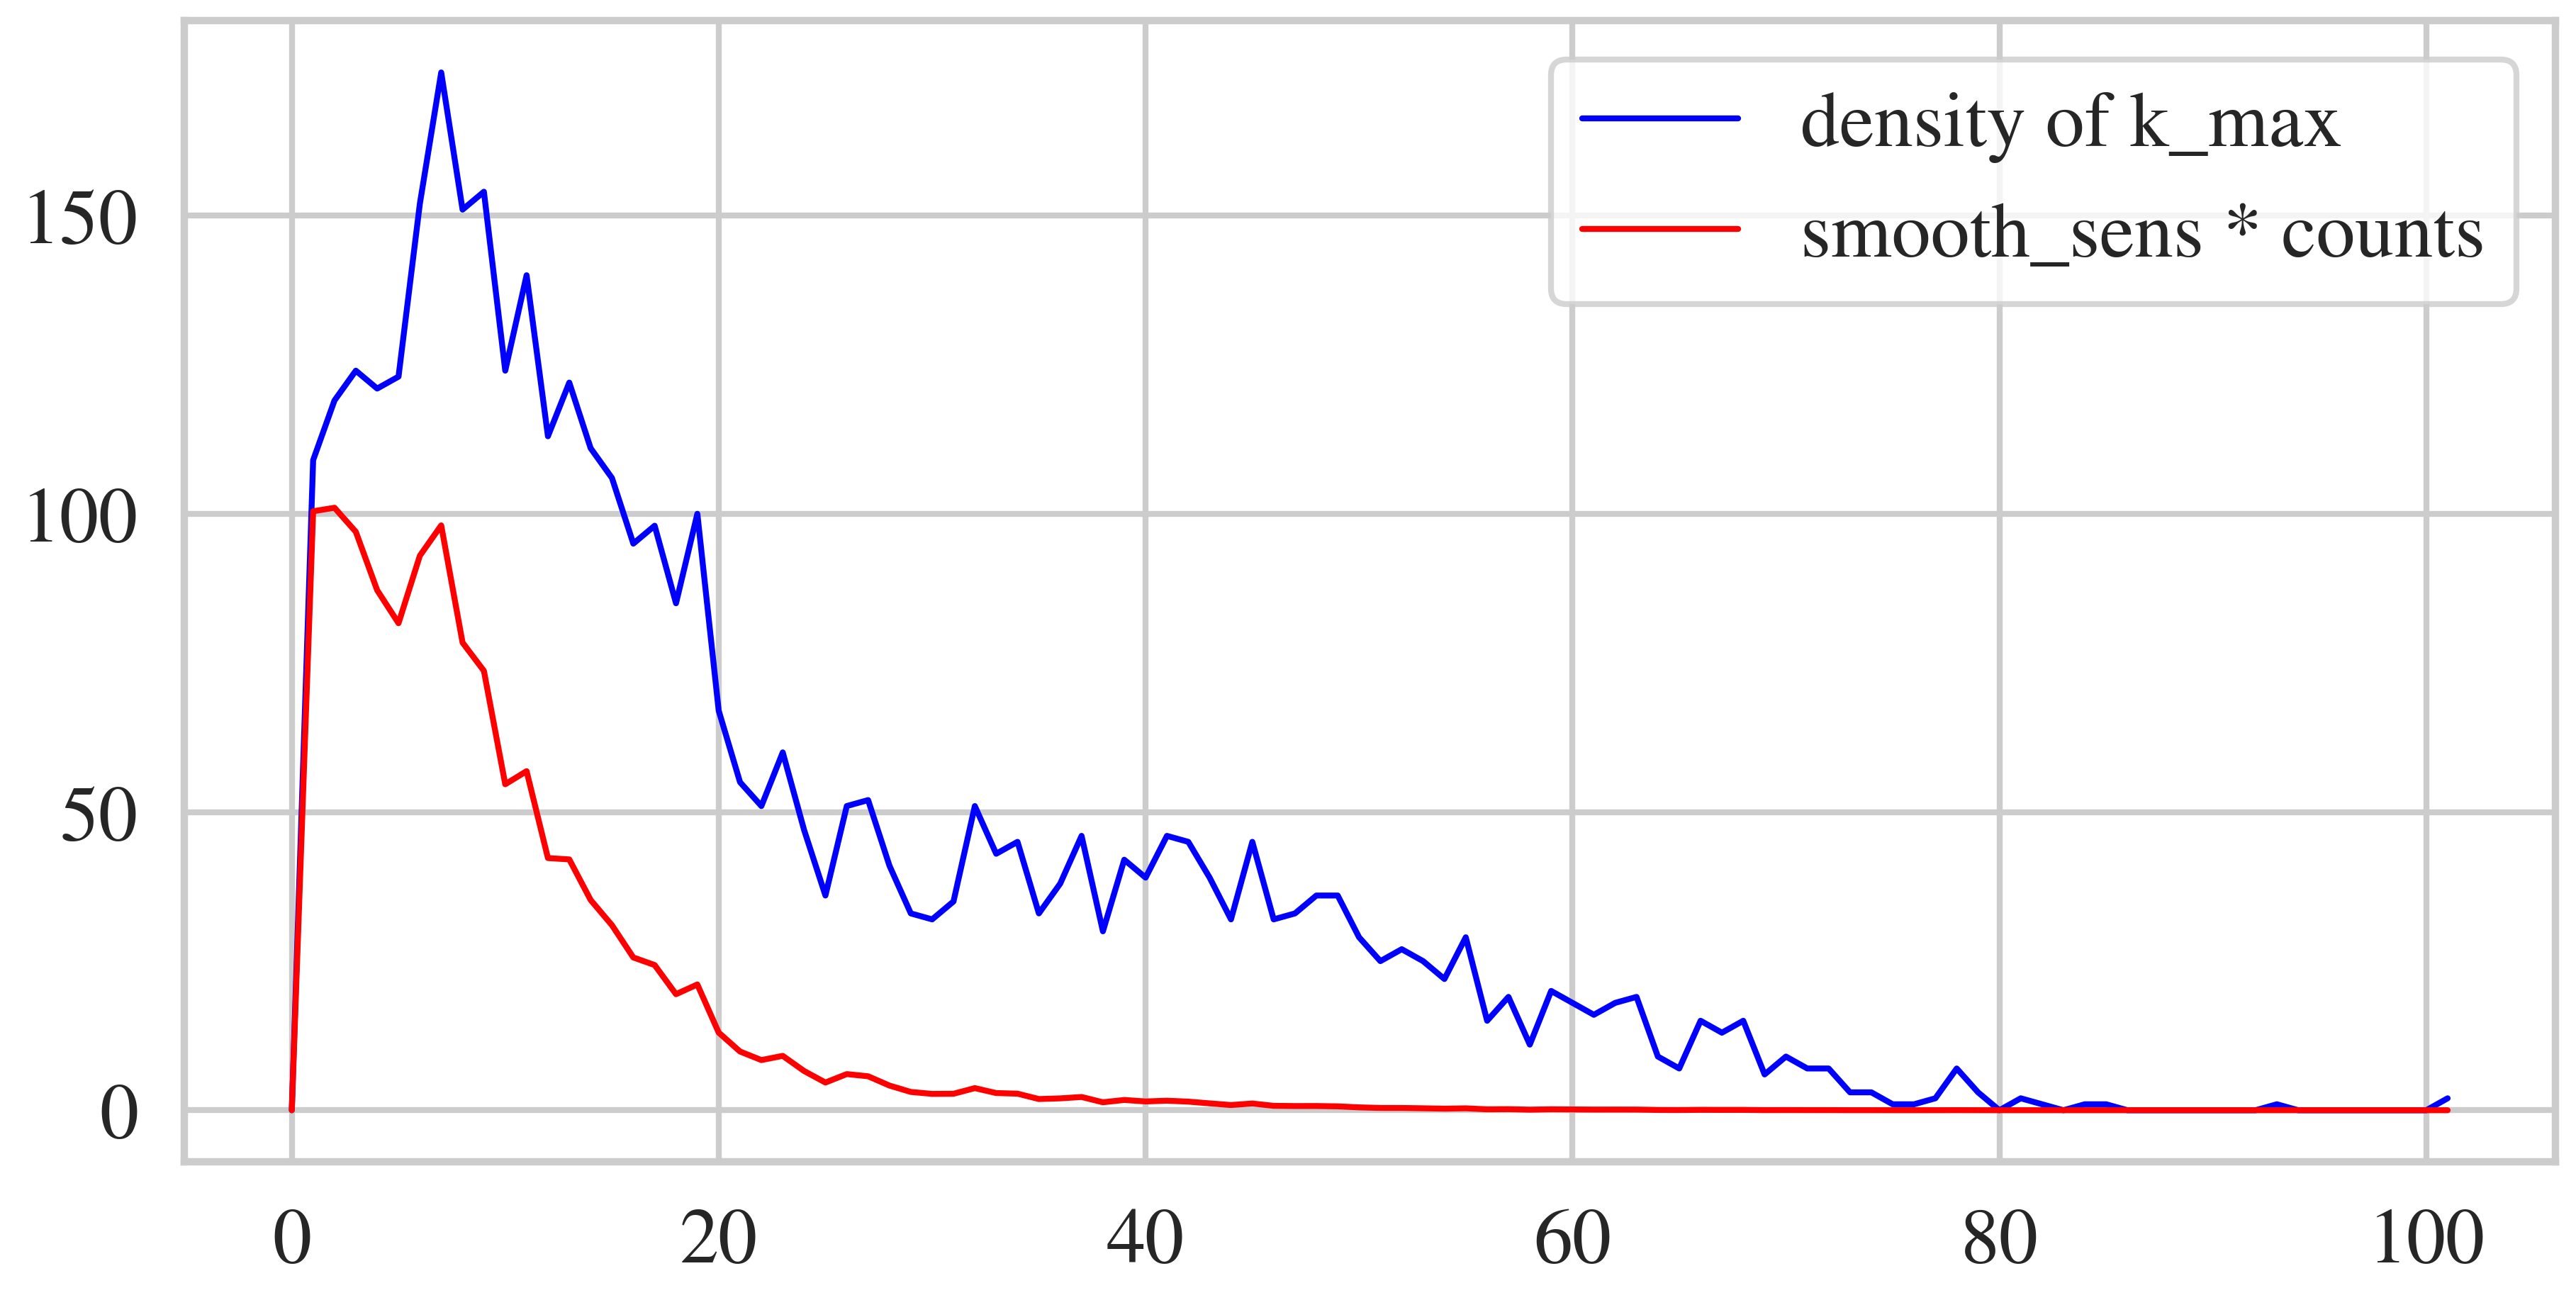

In [11]:
sns.set_theme(context="poster", style="whitegrid", font_scale=1.2)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

fig, axs = plt.subplots(1, 1, figsize=(12, 6), layout="constrained", sharex=True, dpi=300)
k_max = compute_max_certified_k(test_batch, test_labels, privacy_results).cpu().numpy()

epsilon = 1.0
delta = 10 ** -5
beta = epsilon / (2 * math.log(2 / delta))
smooth_sens = np.exp(-2 * beta * np.arange(0, k_max.max() + 1))
counts = np.bincount(k_max)

avg_sens = smooth_sens[k_max].sum() / k_max.size
print(avg_sens)
print((counts * smooth_sens).sum() / k_max.size)

axs.plot(range(len(counts)), counts, color="blue", lw=2, label="density of k_max")
axs.plot(range(len(counts)), counts * smooth_sens, color="red", lw=2, label="smooth_sens * counts")
# axs.plot(range(len(counts)), np.cumsum(counts * smooth_sens) / ((counts * smooth_sens)).sum(), color="green", lw=2)

print(np.cumsum(counts * smooth_sens) / ((counts * smooth_sens)).sum())

axs.legend()

In [12]:
def get_avg_sens(k_select, k_max_full):
    k_select = np.array(k_select)
    epsilon = 1.0
    delta = 10 ** -5
    beta = epsilon / (2 * math.log(2 / delta))
    # k_max = compute_max_certified_k(test_batch, test_labels, {k: privacy_results[k] for k in k_select[:-1]}).cpu().numpy()
    # smooth_sens = np.exp(-2 * beta * k_max)
    k_counts, k_bins = np.histogram(k_max_full, bins=k_select + 1)
    # assert np.allclose((np.exp(-2 * beta * (k_bins[:-1])) * k_counts).sum(), smooth_sens.sum())
    return (np.exp(-2 * beta * (k_bins[:-1])) * k_counts).sum() / len(k_max_full)

def get_good_spacing(start, k_max_full):
    """Compute a good set of k values using a greedy algorithm."""
    k_select = start
    N = len(k_select) - 2
    cur = 1
    it = 0
    same_count = 0
    best = get_avg_sens(k_select, k_max_full)
    while True:
        new = get_avg_sens(k_select, k_max_full)
        if new == best:
            same_count += 1
            if same_count > 4 * N:
                break
        else:
            same_count = 0
        best = min(best, new)
        # print(f"it: {it}, cur: {cur}, best: {best}, ks: {k_select}")
        # change the value of k_select at the current index in the direction of improvement
        if k_select[cur] + 1 == k_select[cur + 1]:
            right = np.inf
        else:
            right = get_avg_sens([k if i != cur else k + 1 for i, k in enumerate(k_select)], k_max_full)
            # print(f"right: {right}, {[k if i != cur else k + 1 for i, k in enumerate(k_select)]}")
        if k_select[cur] - 1 == k_select[cur - 1]:
            left = np.inf
        else:
            left = get_avg_sens([k if i != cur else k - 1 for i, k in enumerate(k_select)], k_max_full)
            # print(f"left: {left}, {[k if i != cur else k - 1 for i, k in enumerate(k_select)]}")
        if left < right and left < best:
            k_select[cur] -= 1
        elif right < new:
            k_select[cur] += 1
        else:
            cur = (cur % (N) + 1)
        it += 1
    # print(f"Final k_select: {k_select}, best: {best}")
    return k_select

res = []

k_max_full = compute_max_certified_k(test_batch, test_labels, privacy_results).cpu().numpy()
# get_avg_sens(np.array([0, 10, 100]), k_max_full)
# start = [0, 1, 5, 10, 50, 100]
# get_good_spacing(start, k_max_full)

res = []

start = np.linspace(0, 100, 10 + 2, dtype=int)
k_select = get_good_spacing(start, k_max_full)
print(k_select)

for N in range(98):
    start = np.linspace(0, 100, N + 2, dtype=int)
    k_select = get_good_spacing(start, k_max_full)
    sens = get_avg_sens(k_select, k_max_full)
    res.append(sens)

[  0   4   7  10  13  17  22  31  41  80  92 100]


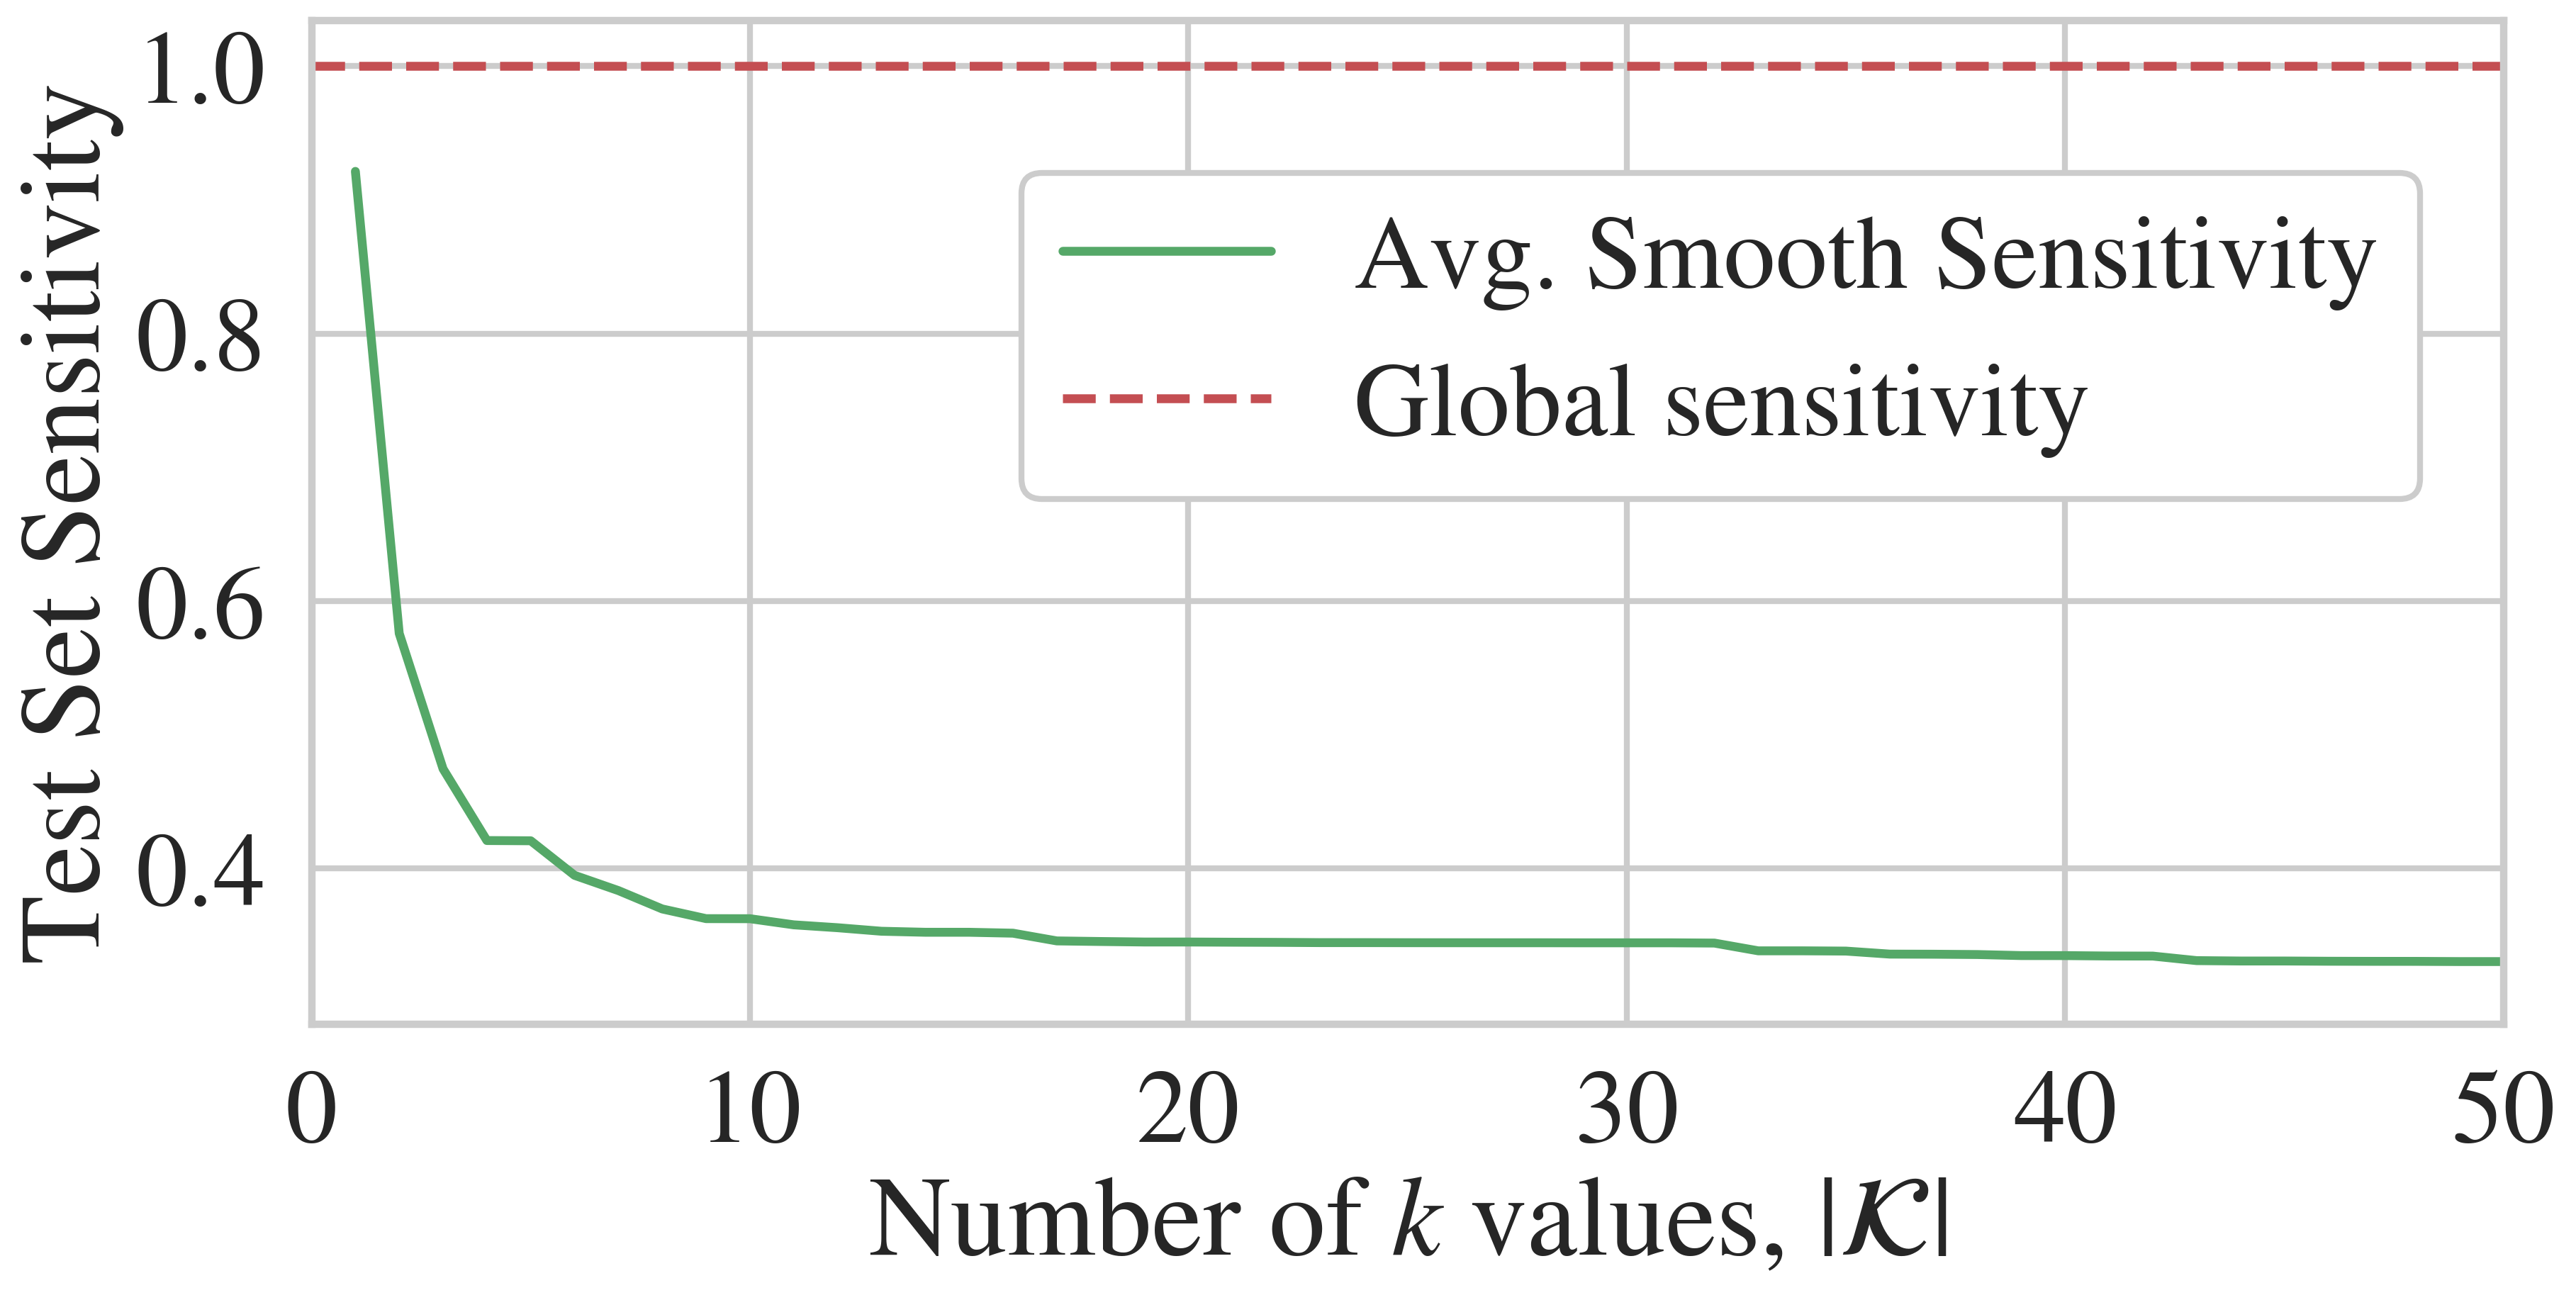

In [13]:
barcolor = sns.color_palette("deep")[0]
laplacecolor = sns.color_palette("deep")[3]
cauchycolor = sns.color_palette("deep")[2]


sns.set_theme(context="poster", style="whitegrid", font_scale=1.6)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

fig, axs = plt.subplots(1, 1, figsize=(12, 6), layout="constrained", sharex=True, dpi=300)
axs.plot(range(1, 99), res, color=cauchycolor, label="Avg. Smooth Sensitivity")
axs.axhline(1 / epsilon, color=laplacecolor, label="Global sensitivity", linestyle="--")
axs.set_ylabel("Test Set Sensitivity")
axs.set_xlim(0, 50)
axs.set_xlabel("Number of $k$ values, $|\mathcal{K}|$")
axs.legend(bbox_to_anchor=(0.3, 0.9), framealpha=1.0)
plt.savefig(".figures/num_k_values.pdf", bbox_inches="tight", dpi=300)

/tmp/ipykernel_2087740/2351956445.py:4: RuntimeWarning: invalid value encountered in divide
  leps = math.log(2 / d) * lambertw(2 * eps * k_max / math.log(2 / d)) / k_max


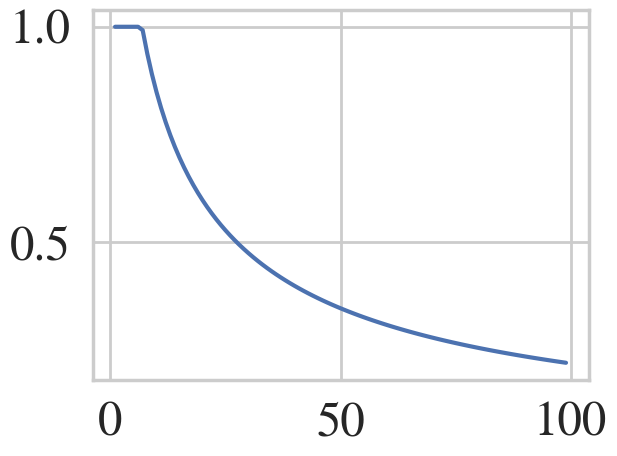

In [14]:
eps = 1.0
d = 10e-5
k_max = np.arange(0, 100)
leps = math.log(2 / d) * lambertw(2 * eps * k_max / math.log(2 / d)) / k_max
leps = torch.tensor(leps.real, device=nominal_config.device).clamp(max=eps)

plt.plot(k_max, leps.cpu().numpy())

In [36]:
epsilons = torch.logspace(-2, 1, 40)

cauchy_means = []
cauchy_stds = []
laplace_means = []
laplace_stds = []

param_n = list(privacy_results.items())[0][1][1]
n_runs = 100

for epsilon in epsilons:
    noise_level = get_cauchy_noise_level(test_batch, test_labels, privacy_results, epsilon) + 1e-8
    private_accs_cauchy = []
    private_accs_laplace = []
    for _ in range(n_runs):
        private_accs_cauchy.append(
            test_metrics.test_accuracy(
                param_n, param_n, param_n,
                test_batch,
                test_labels,
                model=model,
                transform=ct_utils.propagate_conv_layers,
                noise_level=noise_level,
                noise_type="cauchy",
            )[1]
        )
        private_accs_laplace.append(
            test_metrics.test_accuracy(
                param_n, param_n, param_n,
                test_batch,
                test_labels,
                model=model,
                transform=ct_utils.propagate_conv_layers,
                noise_level=float(1 / epsilon),
                noise_type="laplace",
            )[1]
        )
    cauchy_means.append(np.mean(private_accs_cauchy))
    cauchy_stds.append(np.std(private_accs_cauchy))
    laplace_means.append(np.mean(private_accs_laplace))
    laplace_stds.append(np.std(private_accs_laplace))

print(cauchy_means)
print(laplace_means)

[np.float64(0.5006498566269875), np.float64(0.5003574332594871), np.float64(0.5015346363186837), np.float64(0.5008198156952858), np.float64(0.49983756244182587), np.float64(0.49990254640579224), np.float64(0.5000125160813331), np.float64(0.5004898989200592), np.float64(0.5005923727154732), np.float64(0.5010497567057609), np.float64(0.5008997982740402), np.float64(0.5021119925379753), np.float64(0.5033691787719726), np.float64(0.5059685280919075), np.float64(0.5075281384587288), np.float64(0.5097325882315635), np.float64(0.5209547820687294), np.float64(0.5367358356714249), np.float64(0.5588678026199341), np.float64(0.5820345133543015), np.float64(0.6061434924602509), np.float64(0.6261084973812103), np.float64(0.6424019294977188), np.float64(0.6587628334760666), np.float64(0.676138492822647), np.float64(0.692871811389923), np.float64(0.7060810106992722), np.float64(0.715896058678627), np.float64(0.7228368192911148), np.float64(0.726570885181427), np.float64(0.7293951839208603), np.float6

In [37]:
noise_free_acc = test_metrics.test_accuracy(
        param_n, param_n, param_n, test_batch, test_labels, model=model, transform=ct_utils.propagate_conv_layers
    )[1]


In [38]:
delta = 10 ** -5

local_eps = []

for epsilon in epsilons:
    epsilon = float(epsilon)
    local_epsilons = compute_local_epsilons(test_batch, test_labels, privacy_results, epsilon, delta)
    local_eps.append(local_epsilons.mean().item())

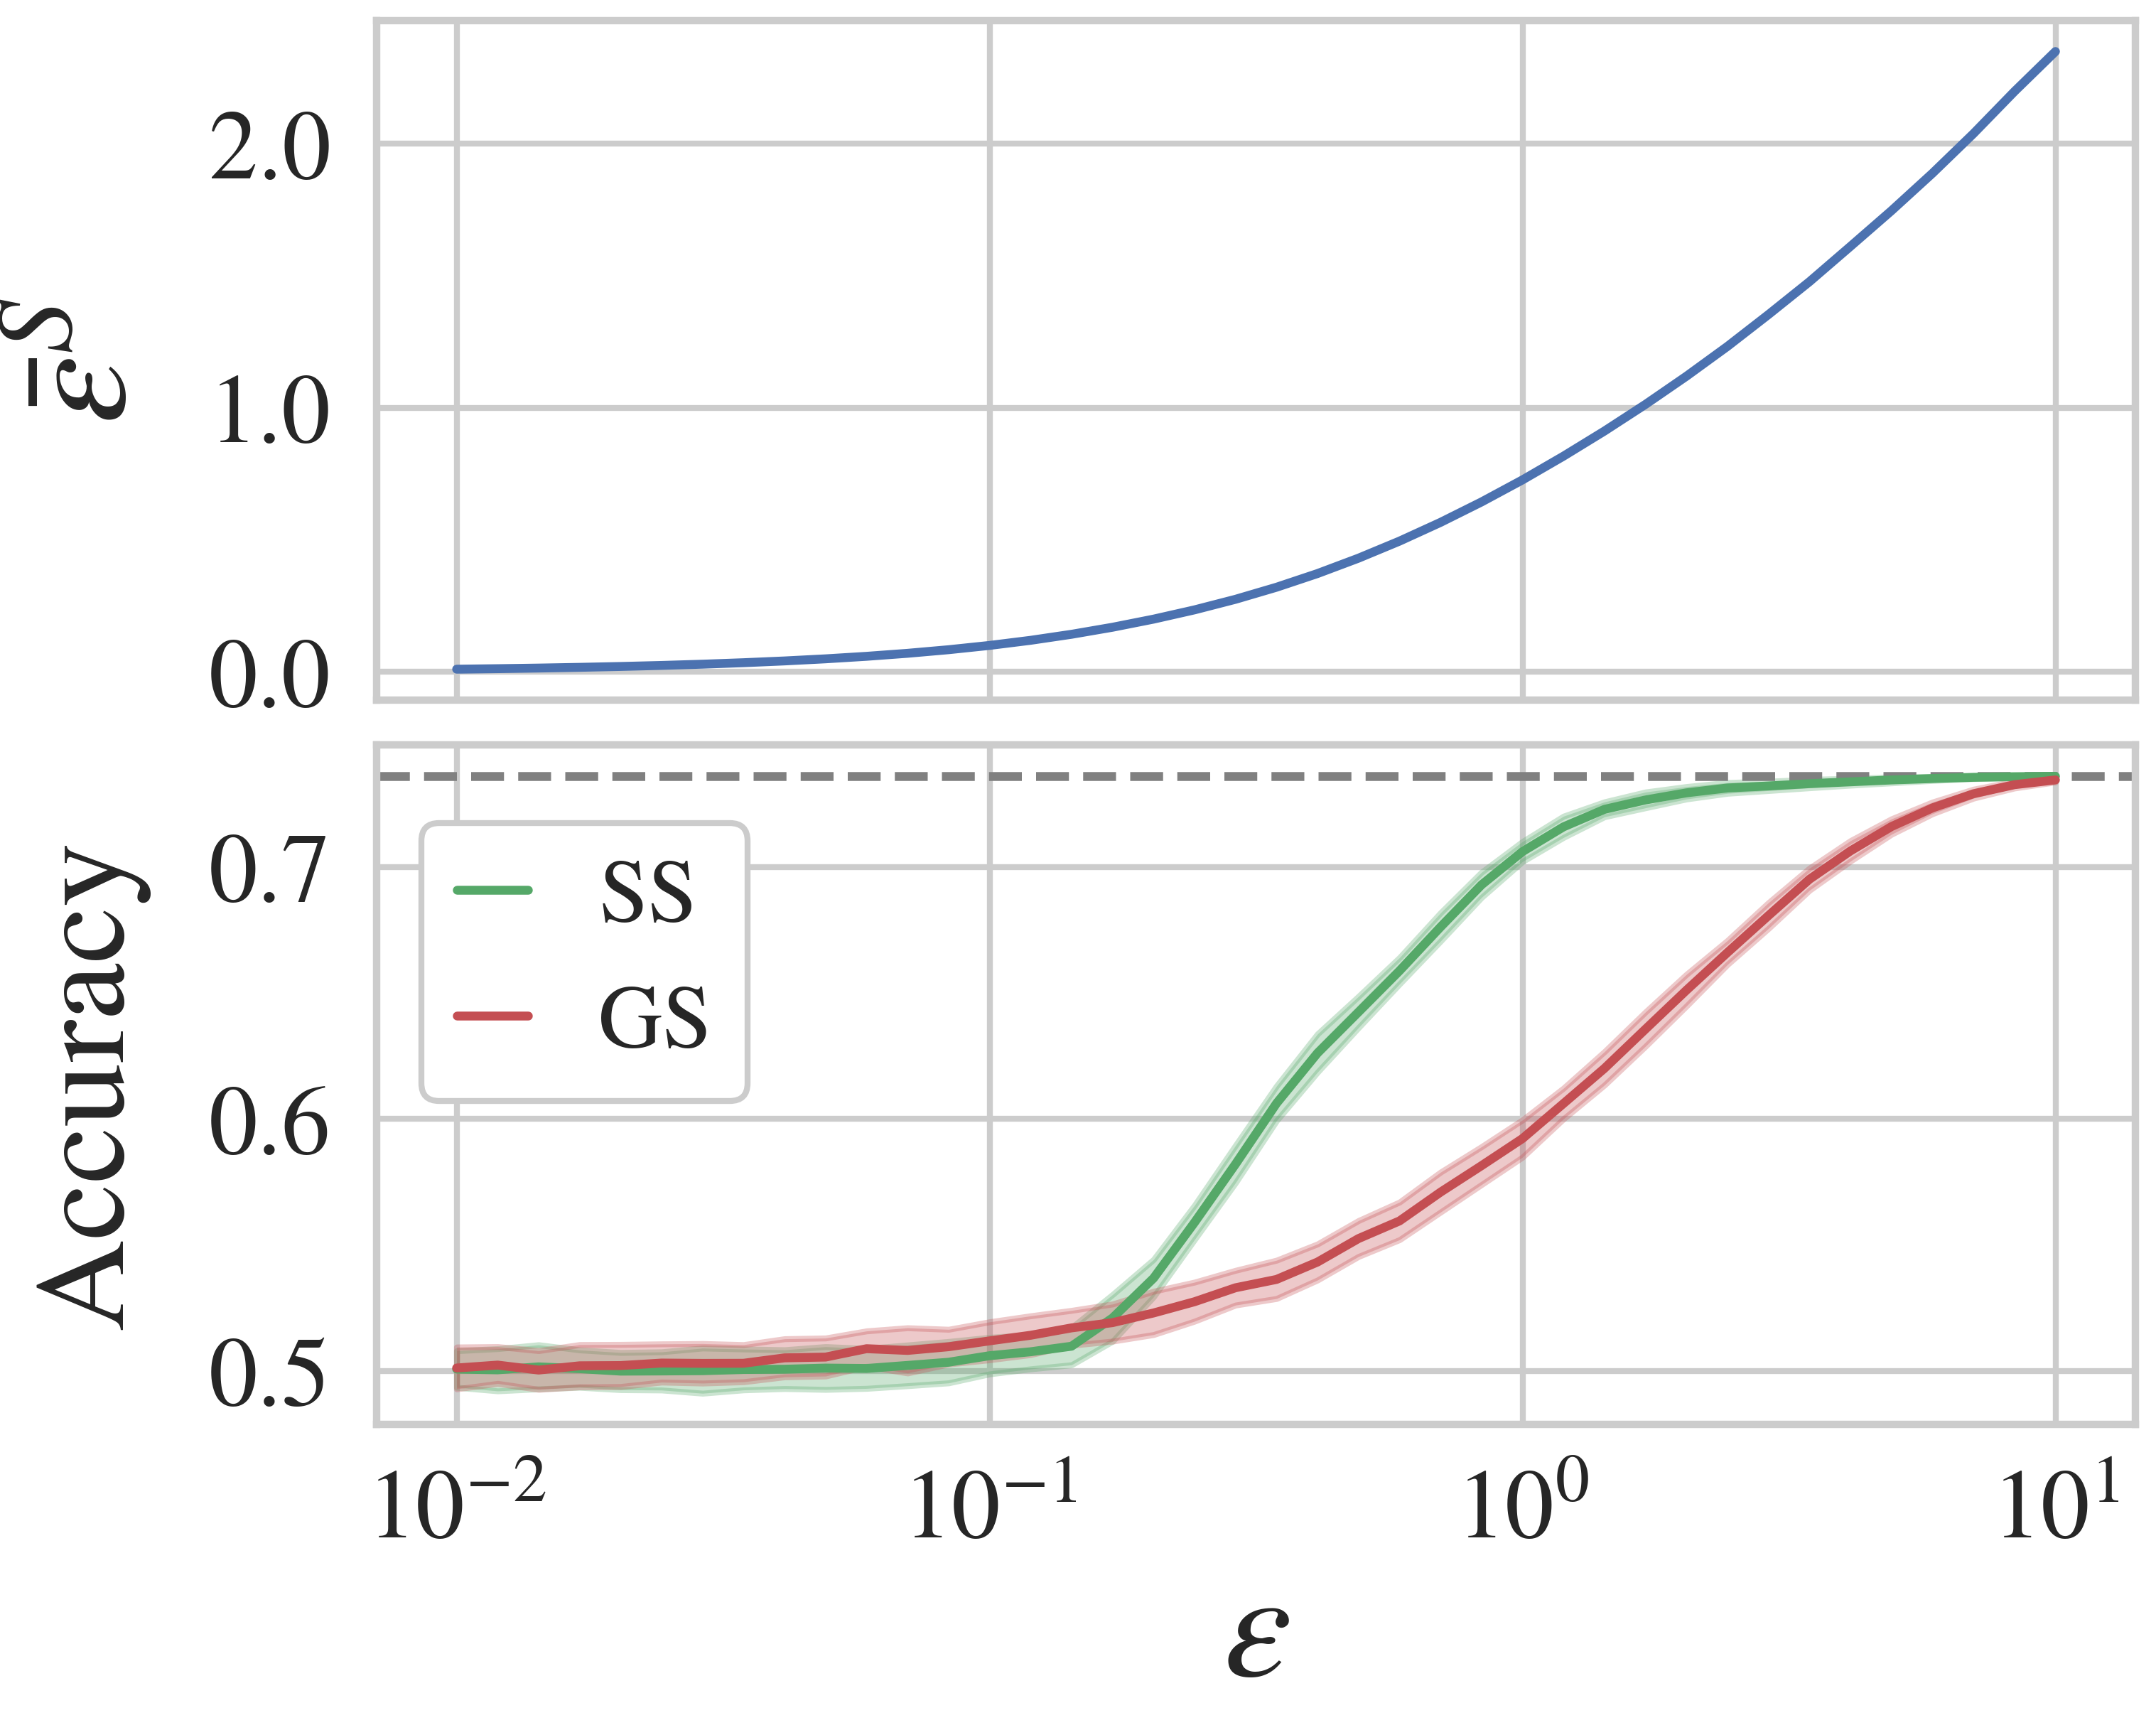

In [39]:
barcolor = sns.color_palette("deep")[0]
laplacecolor = sns.color_palette("deep")[3]
cauchycolor = sns.color_palette("deep")[2]

sns.set_theme(context="poster", style="whitegrid", font_scale=1.5)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

# fig, axs = plt.subplots(2, 1, figsize=(12, 6), layout="constrained", sharex=True, dpi=300)

fig, axs = plt.subplots(2, 1, figsize=(10, 8), layout="constrained", sharex=True, dpi=300)

axs[0].set_xscale("log")
axs[1].set_xlabel("$\epsilon$", fontsize="x-large")

# axs[0].plot(epsilons, np.array(local_eps) / np.array(epsilons), c=barcolor)
axs[0].plot(epsilons, np.array(local_eps), c=barcolor)

axs[1].set_ylabel("Accuracy", fontsize="large", labelpad=20)
axs[0].set_ylabel(r"${\bar{\epsilon}^S}$", fontsize="x-large", labelpad=40, va="center")

axs[1].axhline(noise_free_acc, c="gray", linestyle="--")
axs[1].plot(epsilons, cauchy_means, c=cauchycolor, label="SS")
axs[1].fill_between(
    epsilons,
    np.array(cauchy_means) - np.array(cauchy_stds),
    np.array(cauchy_means) + np.array(cauchy_stds),
    color=cauchycolor,
    alpha=0.3,
)
axs[1].plot(epsilons, laplace_means, c=laplacecolor, label="GS")
axs[1].fill_between(
    epsilons,
    np.array(laplace_means) - np.array(laplace_stds),
    np.array(laplace_means) + np.array(laplace_stds),
    color=laplacecolor,
    alpha=0.3,
)
axs[1].legend(loc="upper left", handlelength=0.8, framealpha=1.0, bbox_to_anchor=(0.0, 0.95), fontsize="small")
axs[0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.1f'))
axs[1].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.1f'))
plt.savefig(".figures/gpt_ss_usage.pdf", bbox_inches="tight", dpi=300)

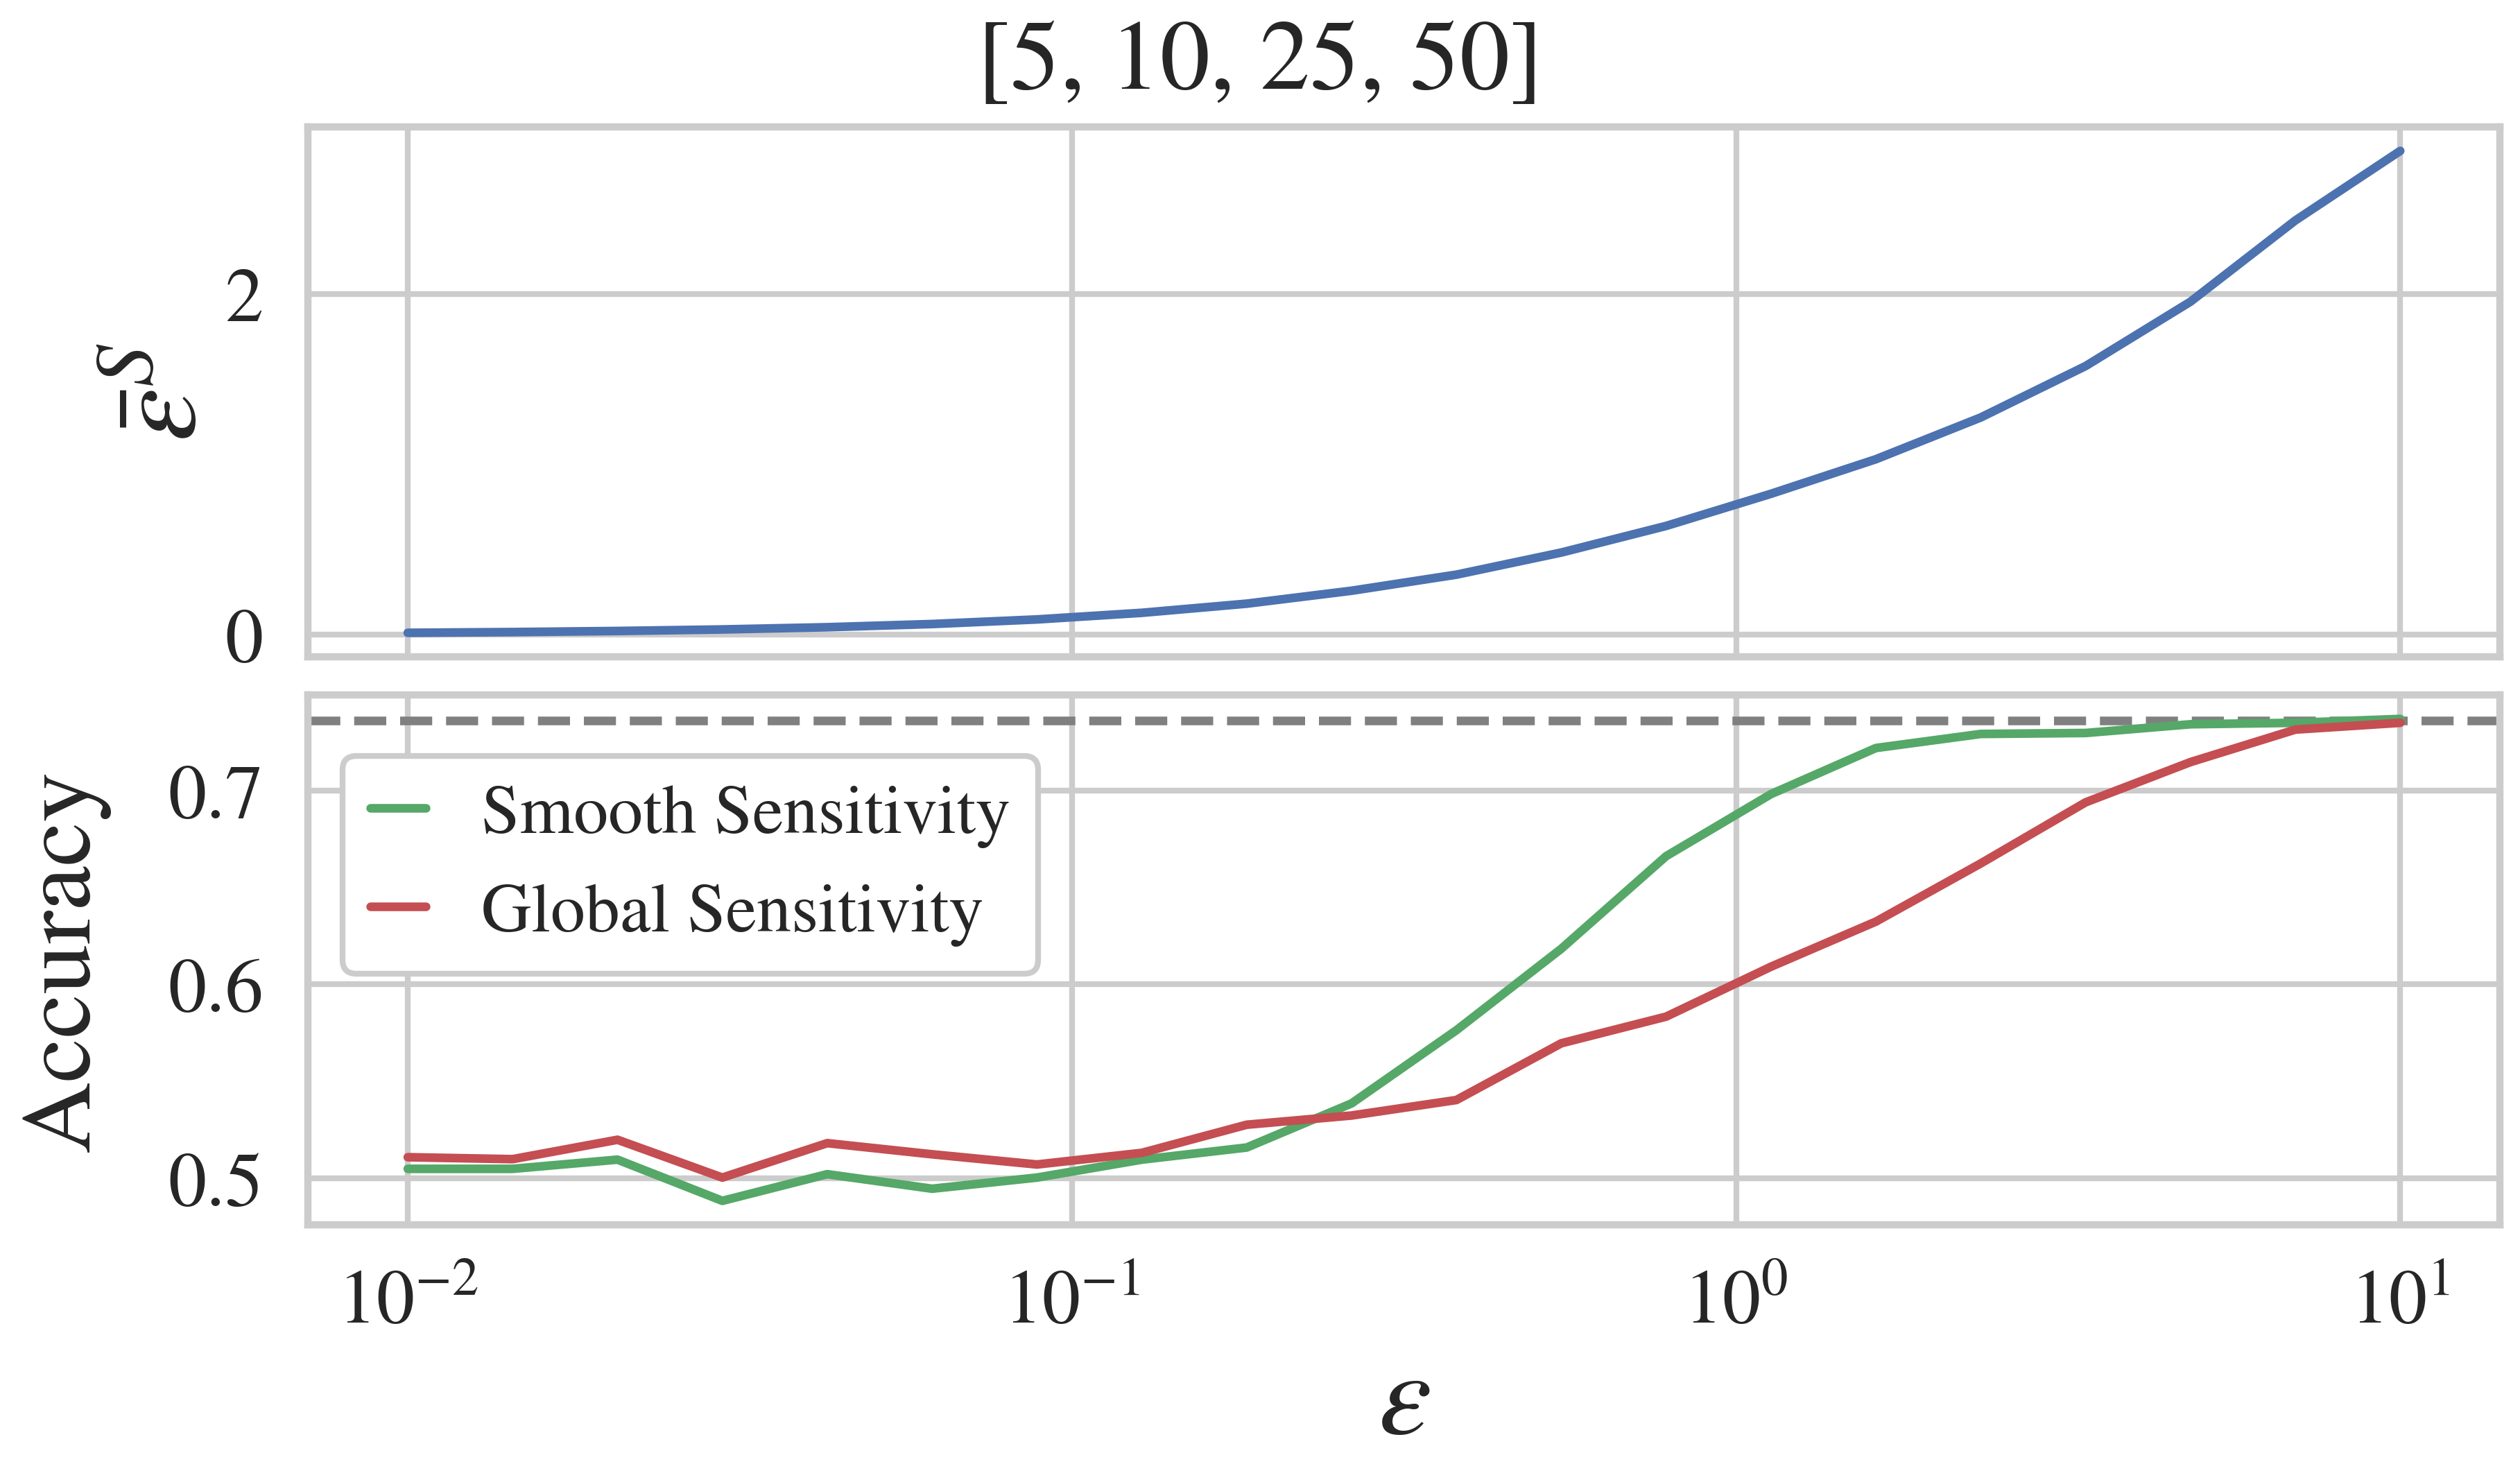

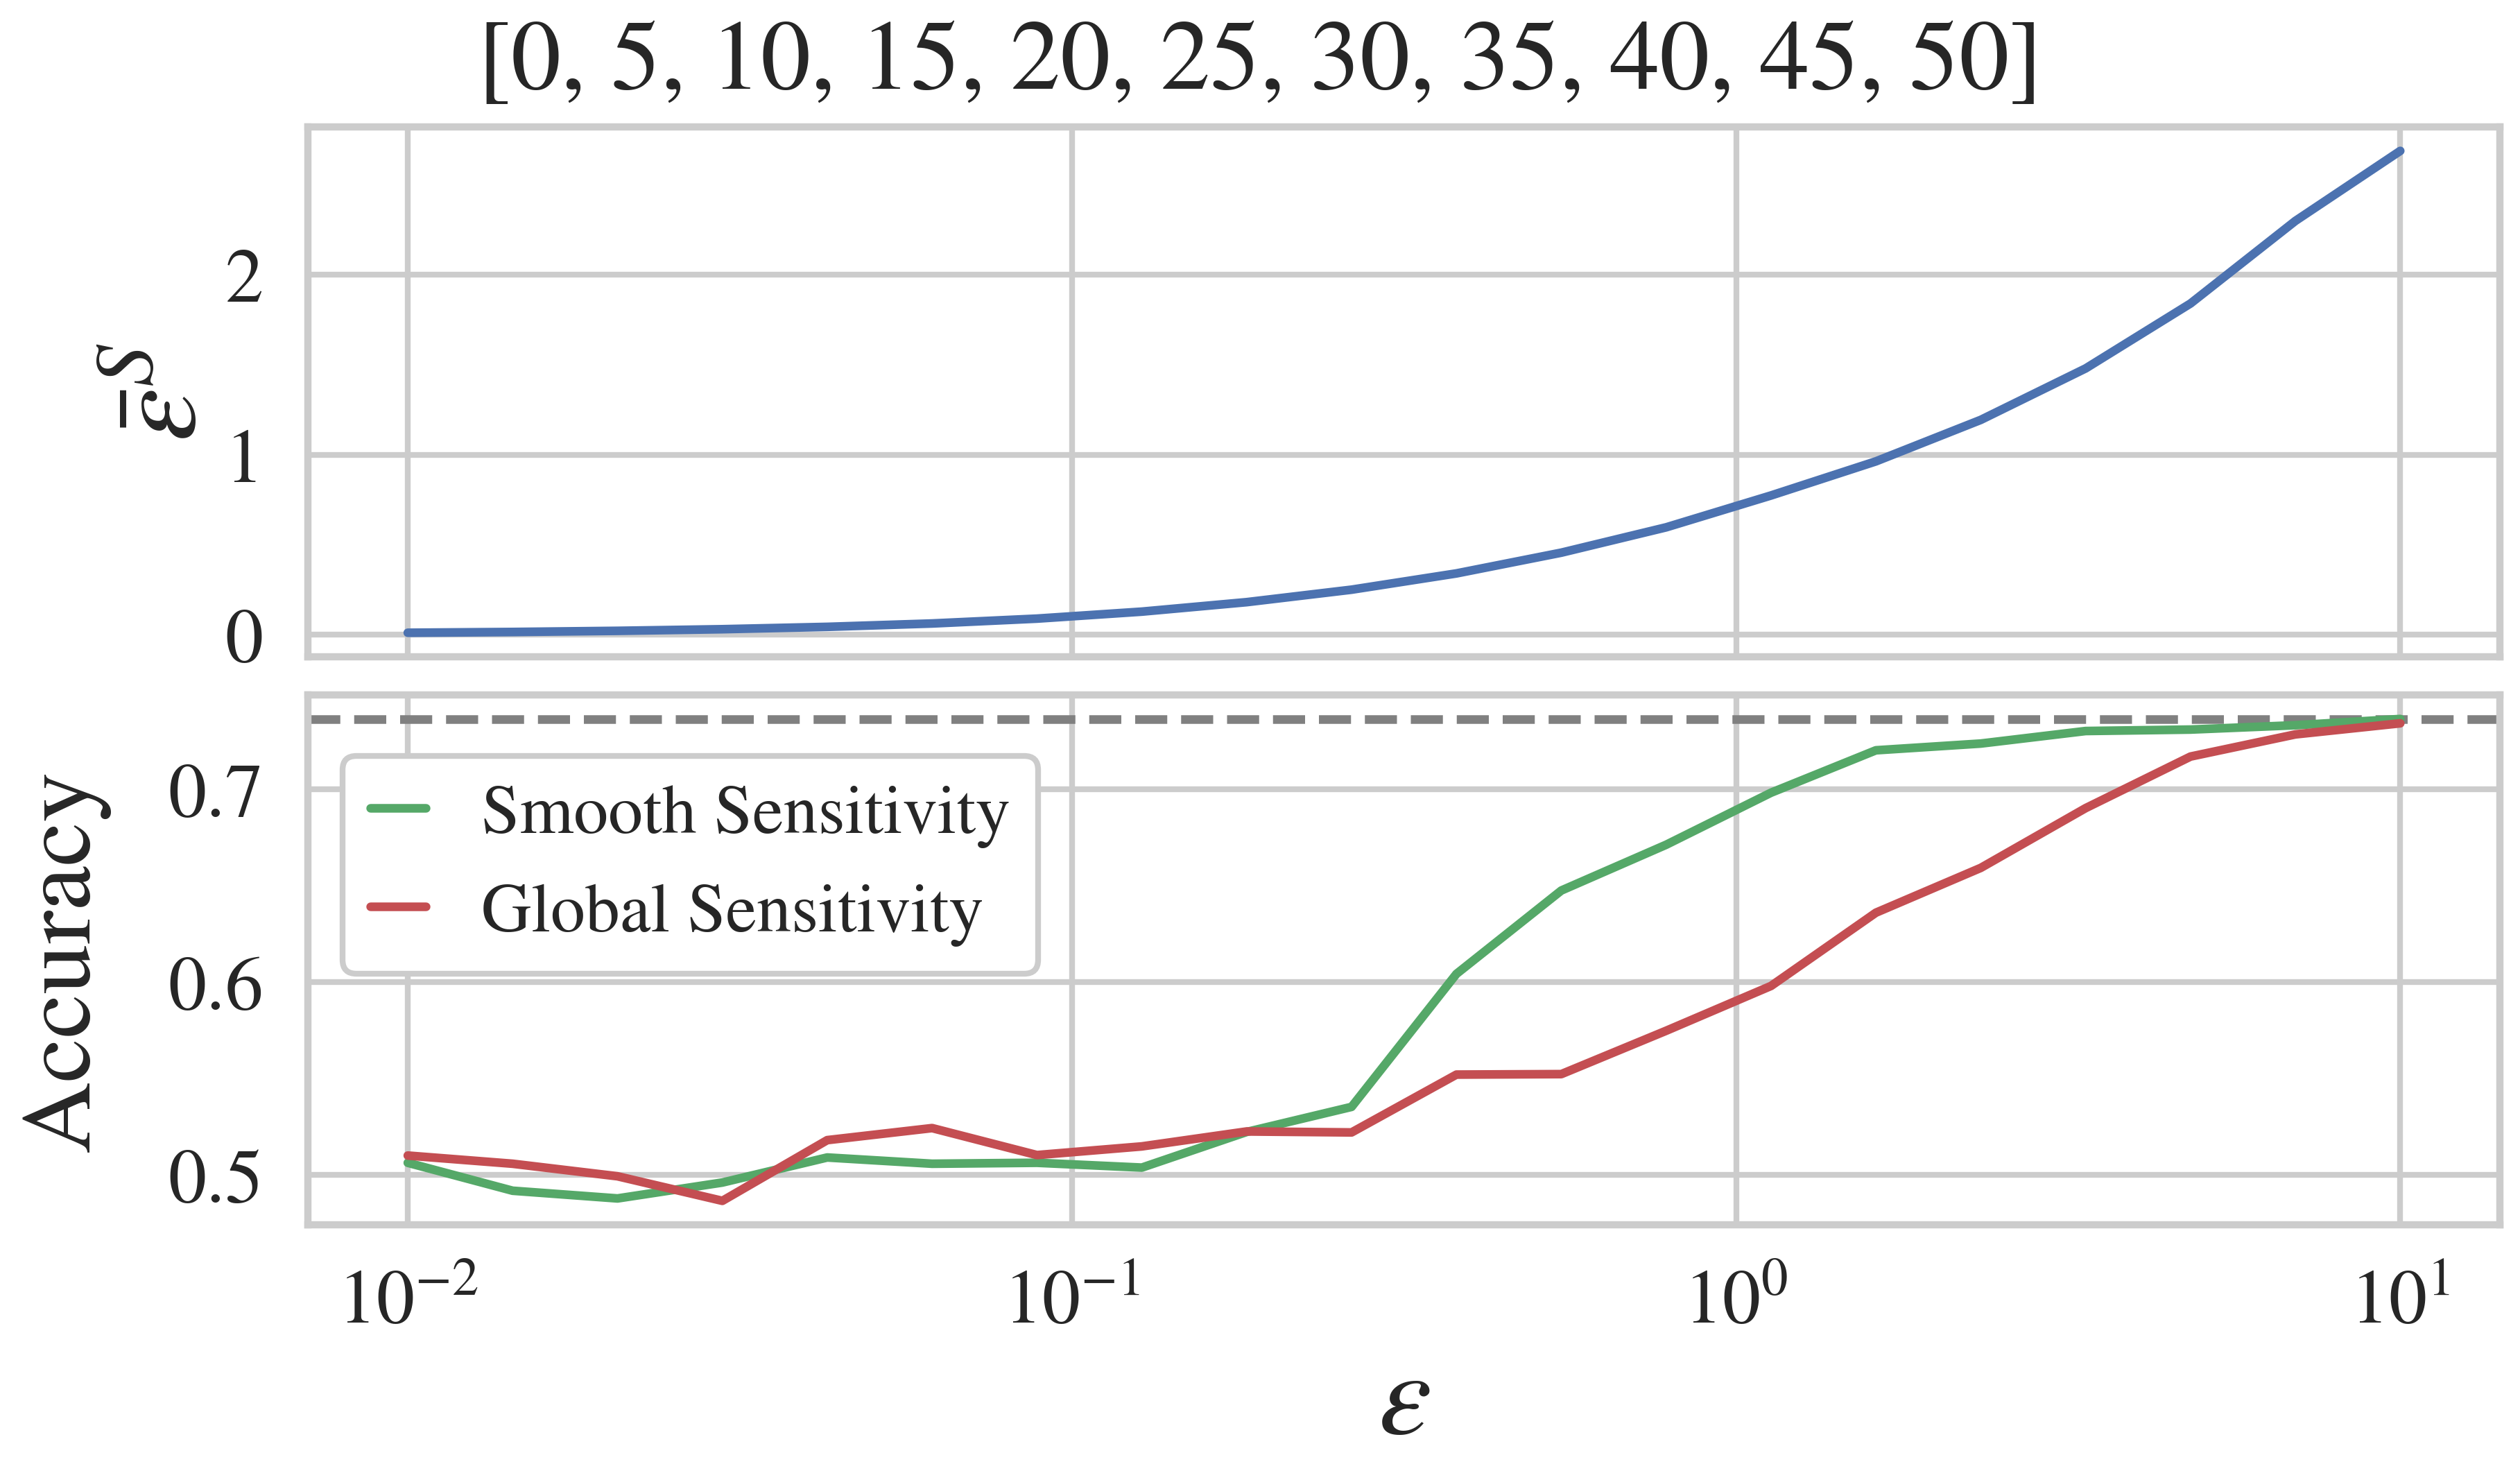

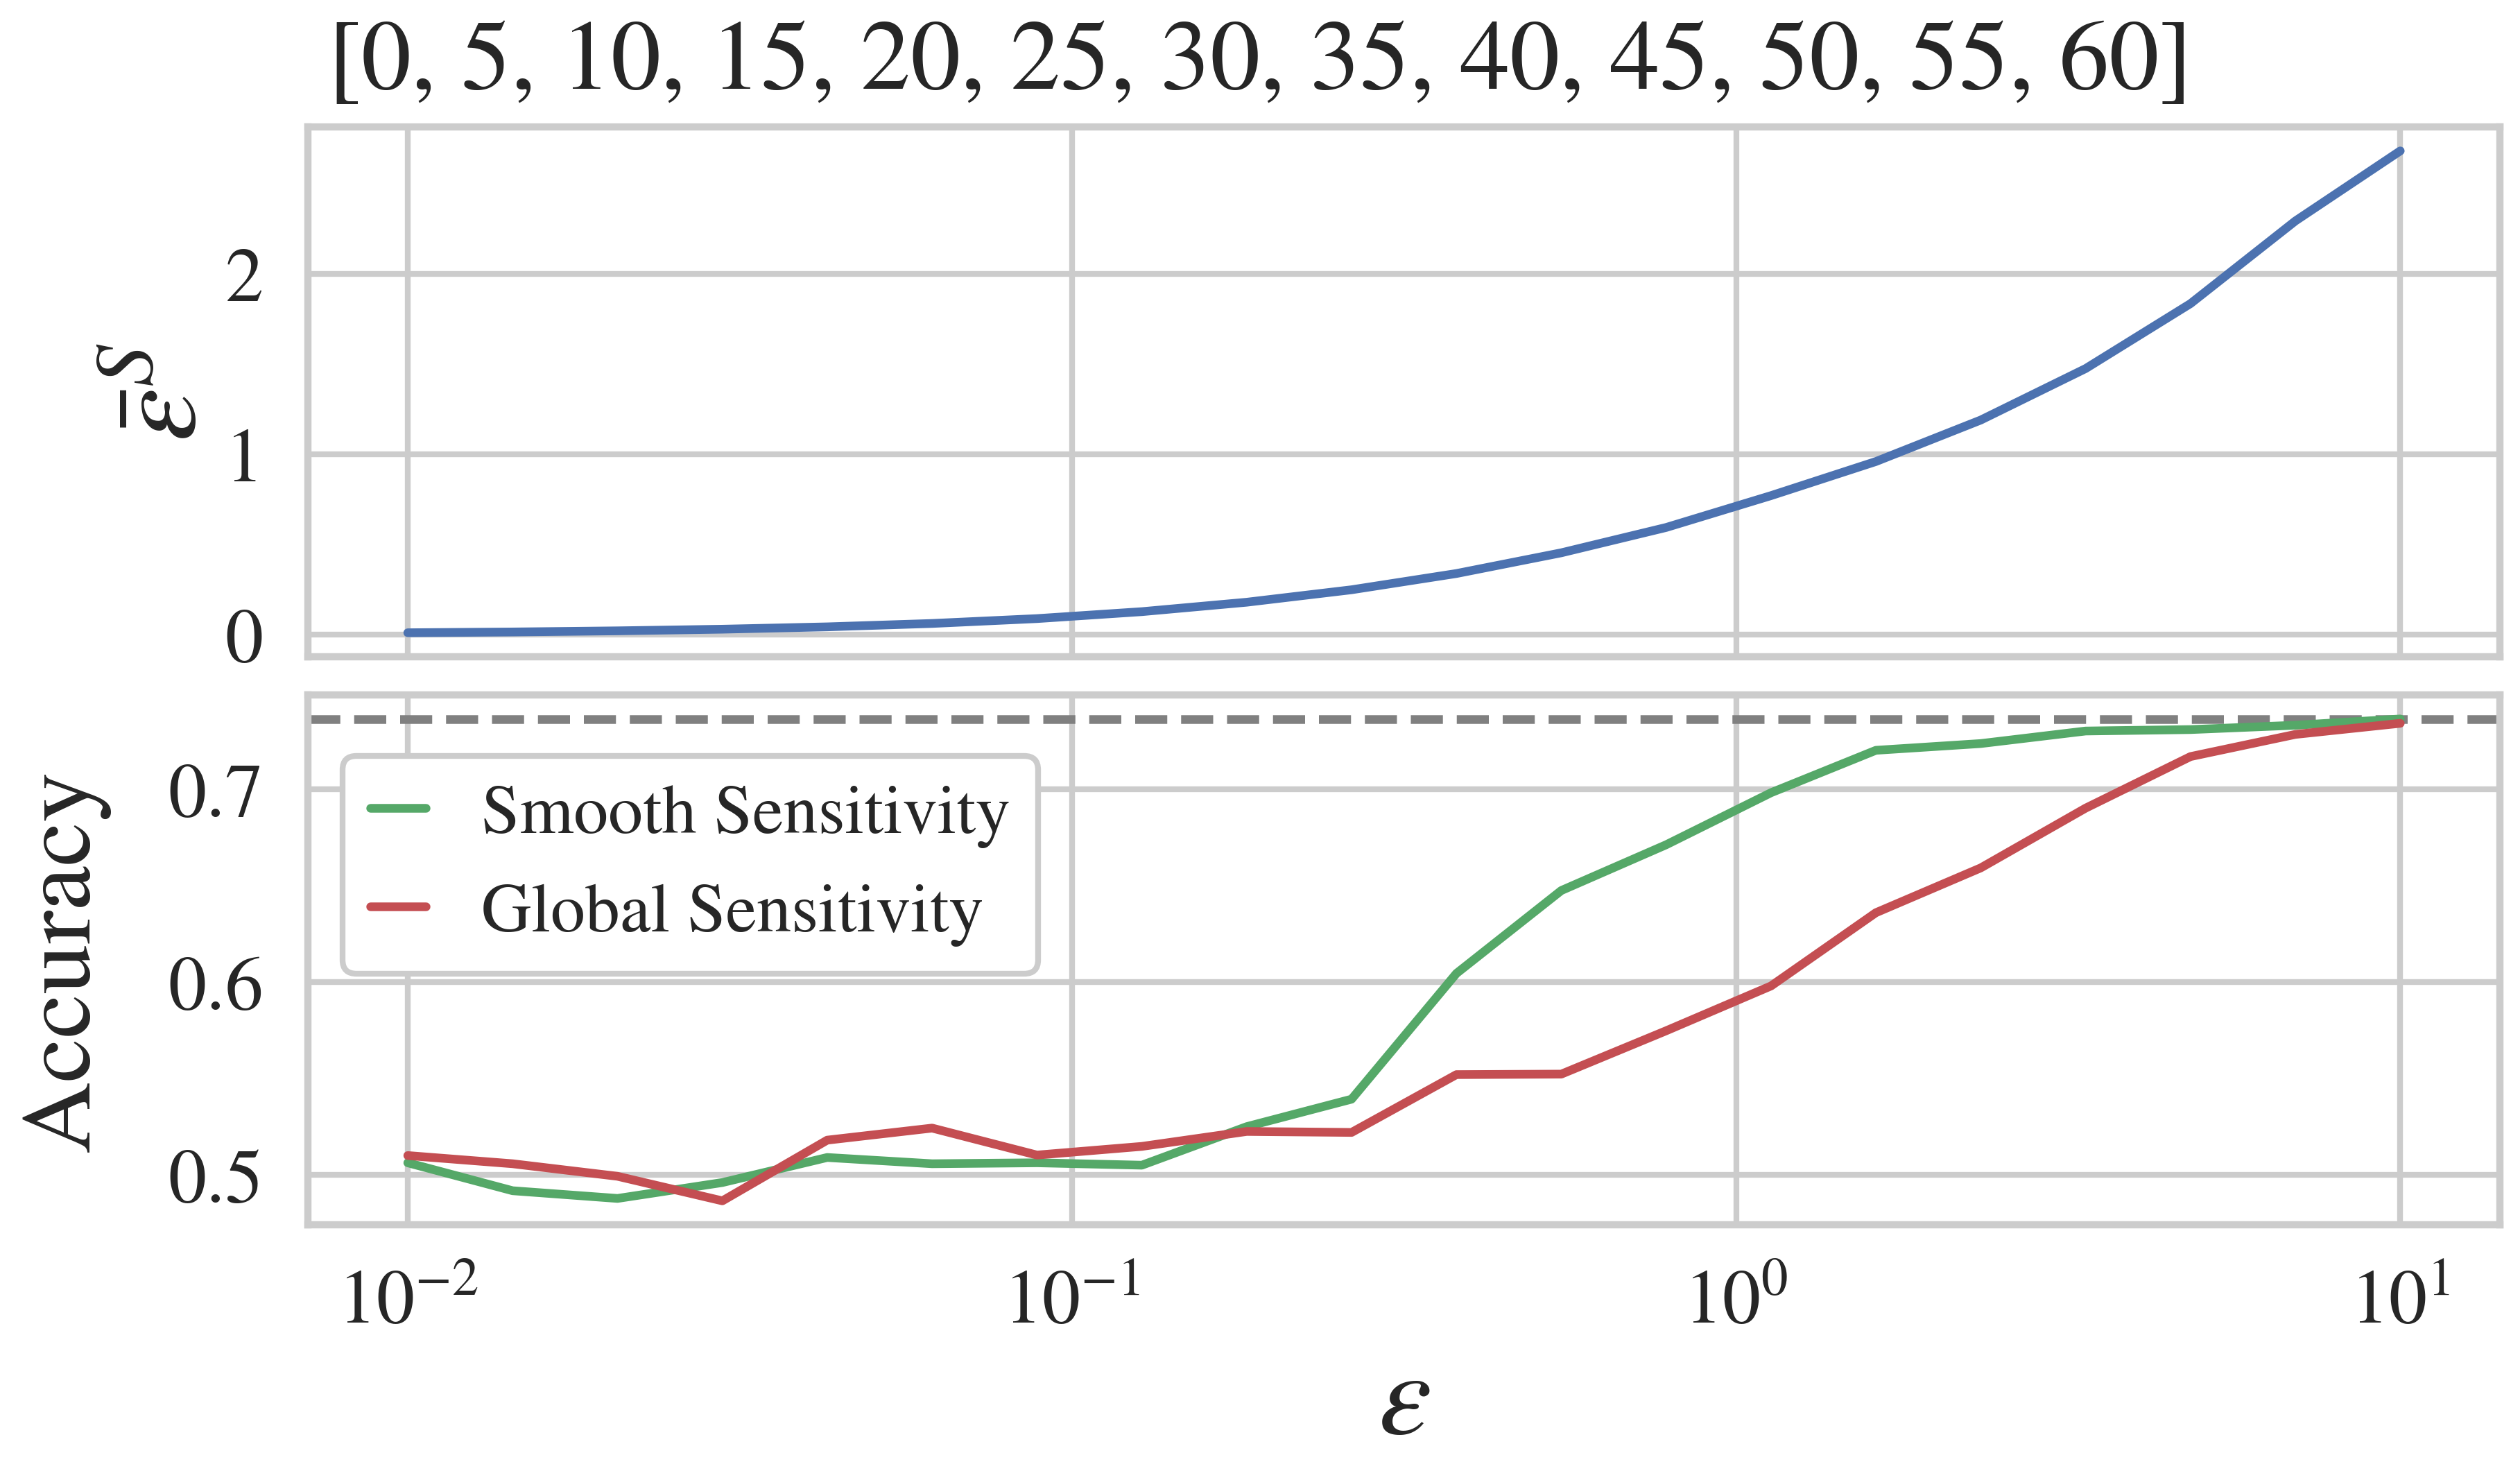

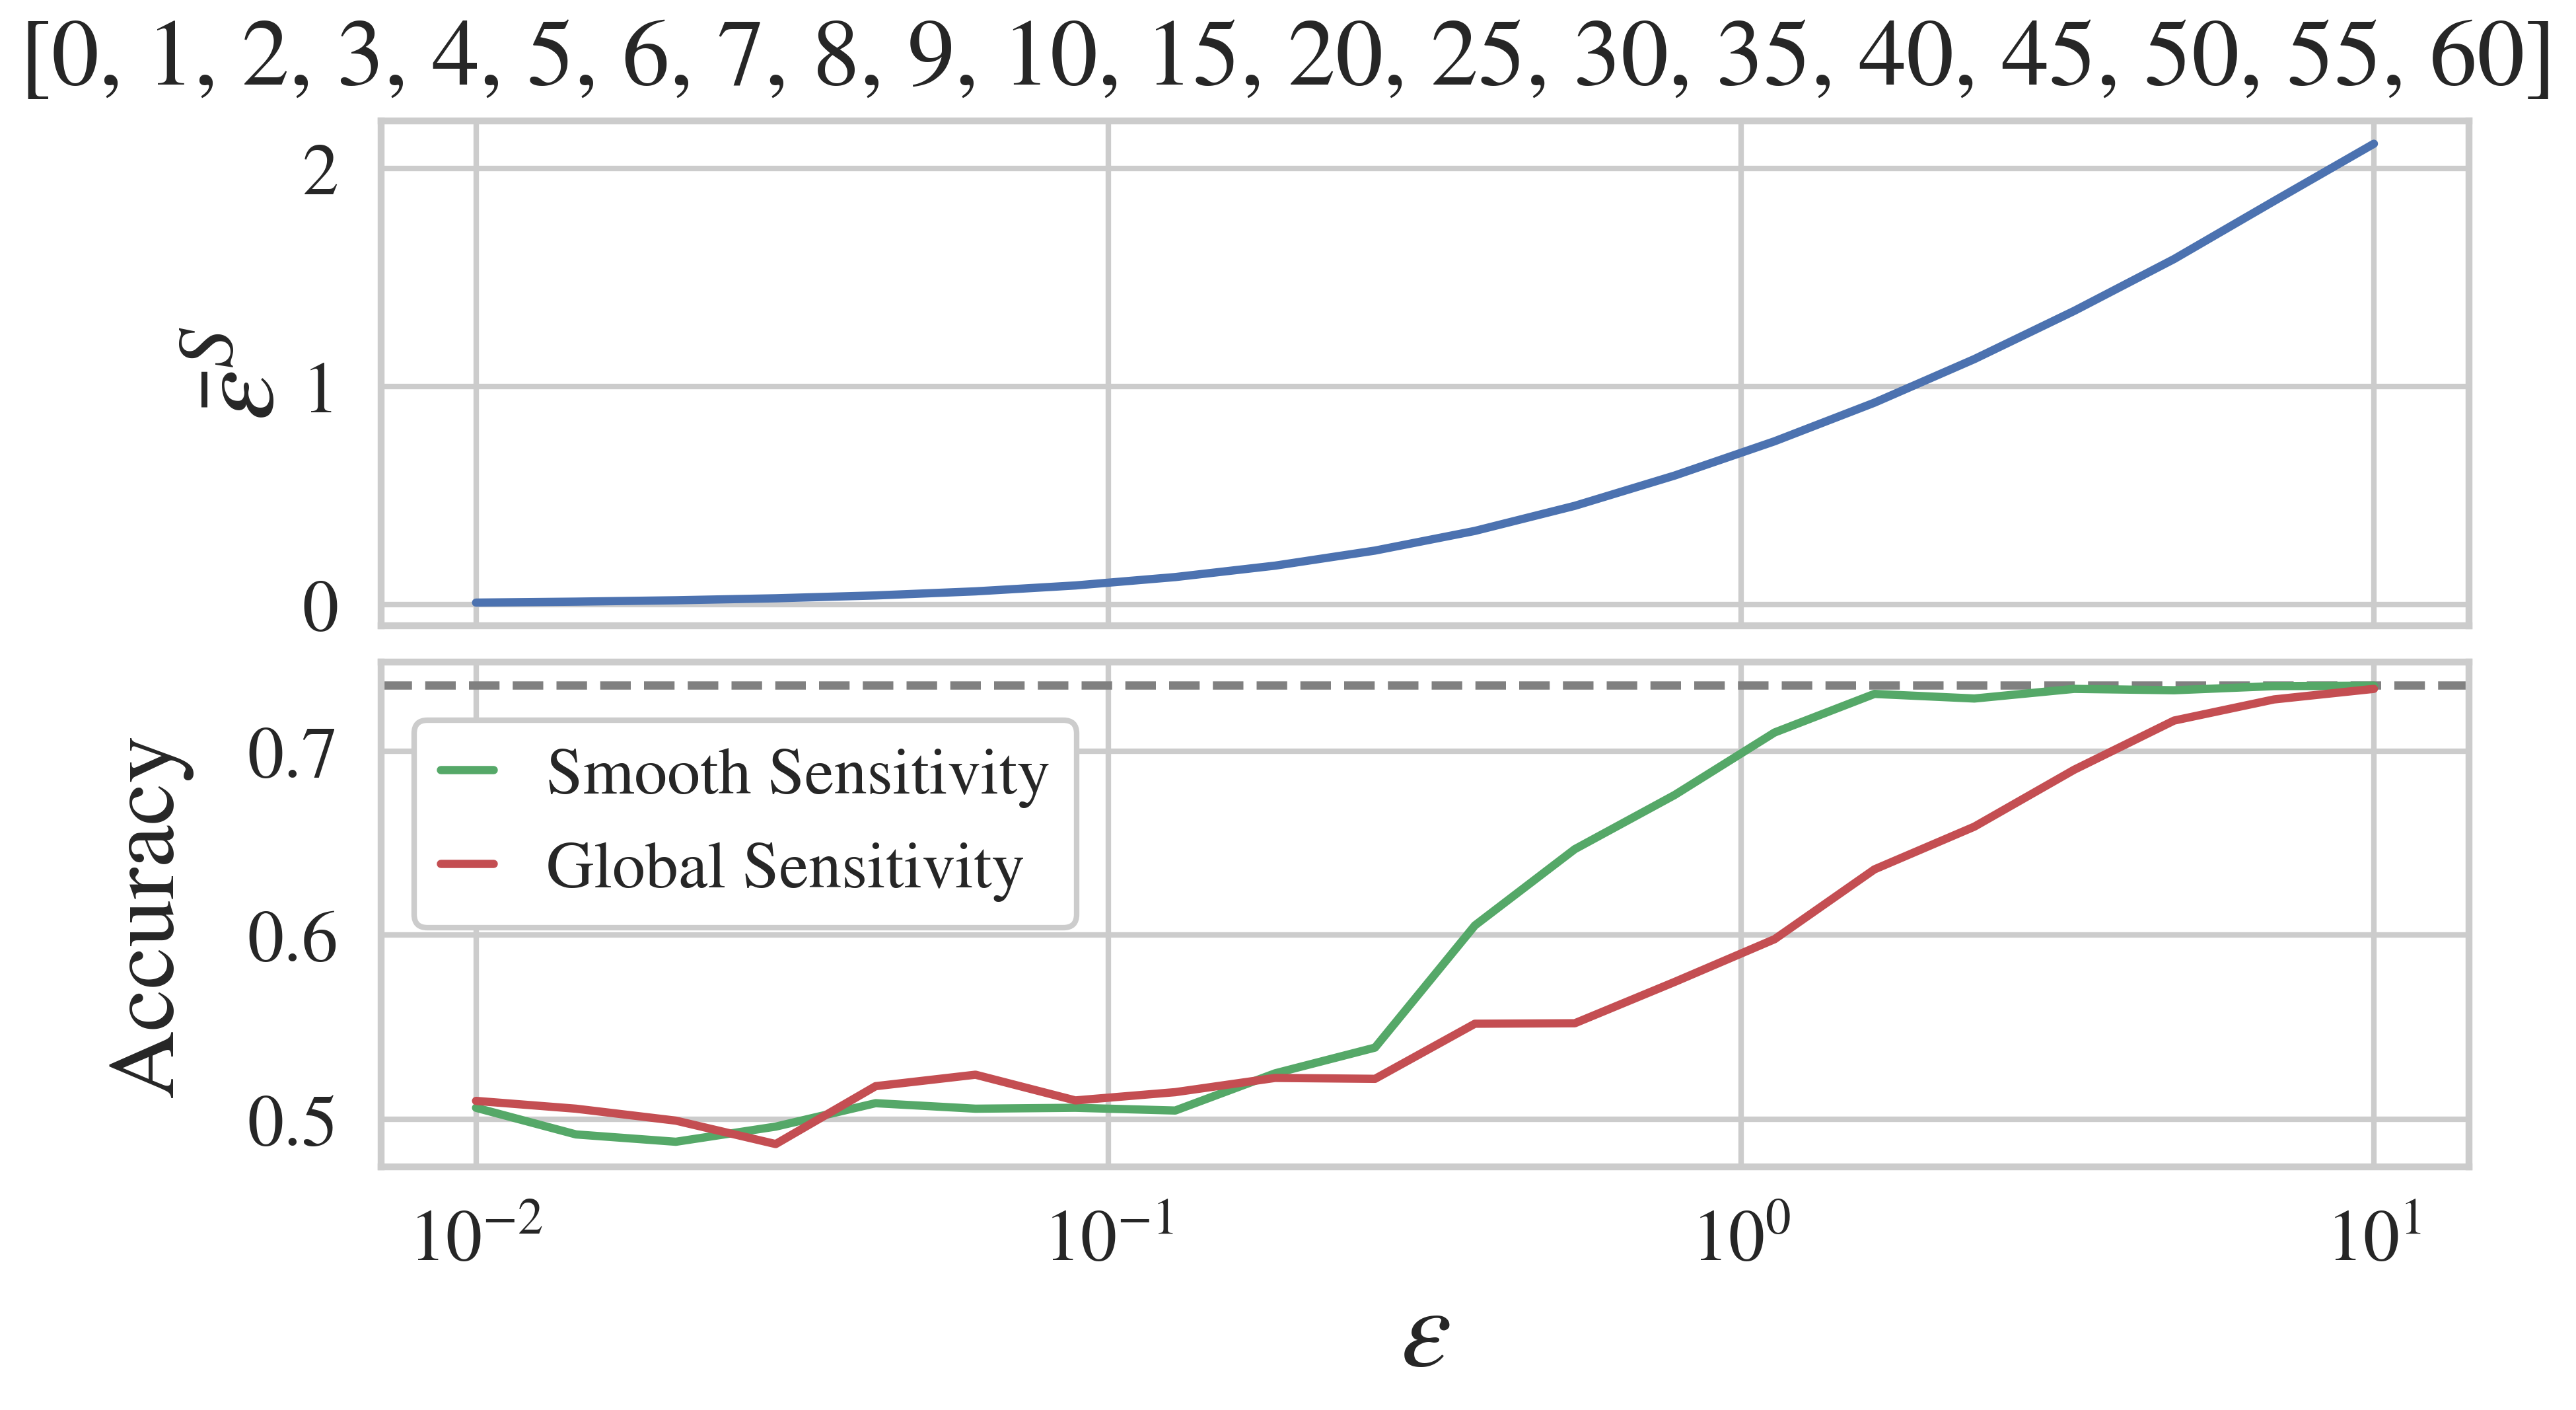

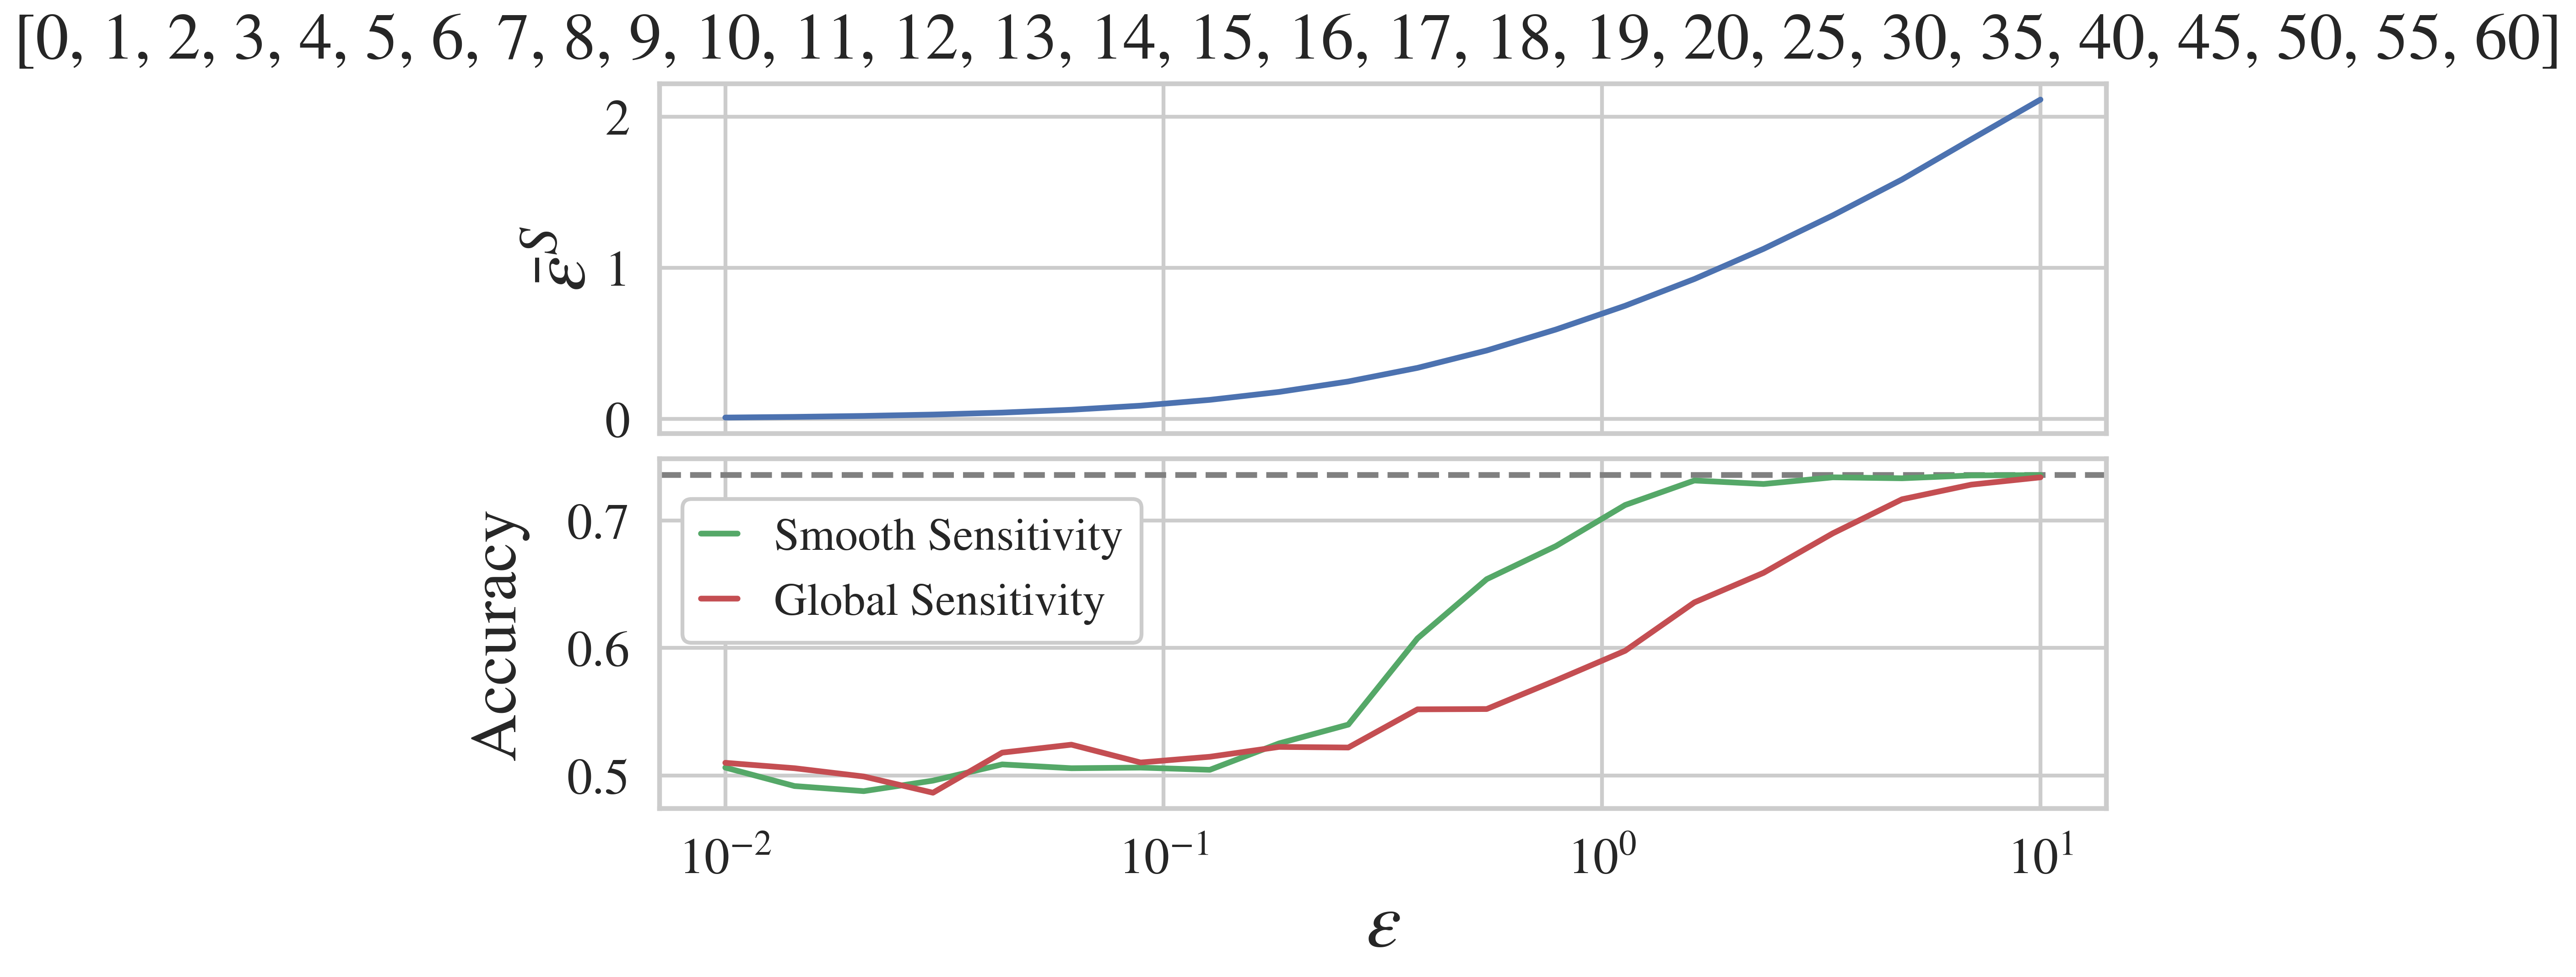